Naming Explanation :
XXXYYZZZ
XXX - ID number of a person who has done the signature. 
YY - Image sample number.
ZZZ - ID number of person whose signature is in photo.

Example: 
NFI-00602023 is an image of signature of person number 023 done by person 006. This is a forged signature.
NFI-02103021 is an image of signature of person number 021 done by person 021. This is a genuine signature.   

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.filters import threshold_otsu

In [2]:
import git
repo = git.Repo('.', search_parent_directories=True)

In [3]:
#Define Path
forge_path = repo.working_tree_dir + "\\forge"
real_path = repo.working_tree_dir + "\\real"

In [4]:
#Preprocessing

def rgbToGray (img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img_gray

def grayToBin(gray_img):

    blur_radius = 0.8
    img = ndimage.gaussian_filter(gray_img, blur_radius)

    thres = threshold_otsu(img)
    binimg = img > thres
    #binimg = np.logical_not(binimg)
    return binimg

def preProcessing(image_path) :
    grayImg = rgbToGray(image_path)
    binaryImg = grayToBin(grayImg)
    return binaryImg

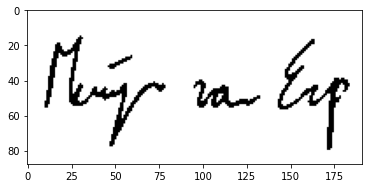

In [7]:
img_path = real_path + "\\00100001.png"
processedImage = preProcessing(img_path)
plt.imshow(processedImage, 'gray')

In [ ]:
# Features Used :
# Centroid : Center of Image.  In case of a grayscale image you can use the pixels' gray values to calculate the weighted average position.
# Ratio ? the ratio of its width to its height
# Eccentricity ? a disparity on an image between the centre of the projected object and the projected location of the centre of an object
# Solidity ? Solidity is useful to quantify the amount and size of concavities in an object boundary. Holes are also often included
# Skewness : meausre of symmetric. if the skewness is negative, the histogram is negatively skewed. The positive skewness is the opposite.
# Kurtosis : is the average (or expected value) of the standardized data raised to the fourth power.